##### Bitcoin Factory Machine Learning


# Multivariate Time Series Forecasting with LSTMs in Keras

## Time Series Forcasting - Multiple Lag Timesteps - Multiple Labels

Based on Tutorial from https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

# Strategy

The strategy is to predict the Candle.Max and Candle.Min of a set of Crypto Assets at the highest timeframe possible, in order to use the prediction to pick the one with higher % of predicted increase in price to take a position in it before that happens.

# Code to Run

## Libraries Used

In [1]:

from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.models import load_model

## Functions Used

In [2]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg 
 

## Load the Instructions Dataset

In [3]:
instructions_dataset = read_csv(
    '/tf/notebooks/instructions.csv', 
    header=0, 
    sep=' ', 
    skipinitialspace=True
)

instructions_dataset

,INSTRUCTION,VALUE
0,ACTION_TO_TAKE,LOAD_MODEL_AND_PREDICT
1,MODEL_FILE_NAME,MODEL-1


In [4]:
# what are we going to do in the current run?
ACTION_TO_TAKE = instructions_dataset.values[0][1]

# name of the model file to load or save.
MODEL_FILE_NAME = instructions_dataset.values[1][1]

## Load the Parameters Dataset


In [5]:
parameters_dataset = read_csv(
    '/tf/notebooks/parameters.csv', 
    header=0, 
    sep=' ', 
    skipinitialspace=True
)

parameters_dataset

,PARAMETER,VALUE
0,LIST_OF_ASSETS,BTC
1,LIST_OF_TIMEFRAMES,01-hs
2,NUMBER_OF_INDICATORS_PROPERTIES,5
3,NUMBER_OF_LAG_TIMESTEPS,9
4,NUMBER_OF_ASSETS,1
5,NUMBER_OF_LABELS,3
6,PERCENTAGE_OF_DATASET_FOR_TRAINING,80
7,NUMBER_OF_FEATURES,5
8,NUMBER_OF_EPOCHS,2
9,NUMBER_OF_LSTM_NEURONS,50


In [6]:
# number of indicator properties that are at the raw dataset. Each set of indicators properties might be at many assets or timeframes.
NUMBER_OF_INDICATORS_PROPERTIES = int(parameters_dataset.values[2][1])

# number of timesteps in the secuence that we are going to use to feed the model.
NUMBER_OF_LAG_TIMESTEPS = int(parameters_dataset.values[3][1])

# number of assets included at the raw dataset.
NUMBER_OF_ASSETS = int(parameters_dataset.values[4][1])

# number of things we are going to predict.
NUMBER_OF_LABELS = int(parameters_dataset.values[5][1])

# definition of how the raw dataset is going to be divided between a Traing Dataset and a Test Dataset.
PERCENTAGE_OF_DATASET_FOR_TRAINING = int(parameters_dataset.values[6][1])

NUMBER_OF_FEATURES = int(parameters_dataset.values[7][1])

# hyper-parameters
NUMBER_OF_EPOCHS = int(parameters_dataset.values[8][1])
NUMBER_OF_LSTM_NEURONS = int(parameters_dataset.values[9][1])

## Load the Time-Series Dataset

In [7]:
timeseries_dataset = read_csv(
    '/tf/notebooks/time-series.csv', 
    header=0, 
    index_col=0,    #The first colum is a timestamp that will be used to index all the data.
    sep=' ', 
    skipinitialspace=True
)

timeseries_dataset

,BTC-candle.max-01-hs-1,BTC-candle.min-01-hs-1,BTC-candle.open-01-hs-1,BTC-candle.close-01-hs-1,BTC-volume.total-01-hs-1
Timestamp,,,,,
1502942400000,4313.62,4261.32,4261.48,4308.83,47.181009
1502946000000,4328.69,4291.37,4308.83,4315.32,23.234916
1502949600000,4345.45,4309.37,4315.32,4324.35,7.229691
1502953200000,4349.99,4287.41,4324.35,4349.99,4.443249
1502956800000,4377.85,4333.32,4333.32,4360.69,0.972807
...,...,...,...,...,...
1648440000000,47218.88,46864.40,47049.40,47124.80,1410.573460
1648443600000,47371.99,47011.38,47124.80,47056.19,4718.796400
1648447200000,47106.24,46716.83,47056.19,46904.73,3764.161810


## Duplicate the Last Record

The reframing process shift each record to the left of the shifting window, producing that the last record of data is ignored at the last prediction. To fix this we will duplicate the last record so that the last prediction belongs to the the last piece of information available.

In [8]:
values = timeseries_dataset.values

In [9]:
last_record = values[-1:,:]
last_record

array([[47053.25   , 46845.98   , 46989.24   , 47021.24   ,  1568.21655]])

In [10]:
all_records = concatenate((values, last_record), axis=0)
all_records

array([[4.31362000e+03, 4.26132000e+03, 4.26148000e+03, 4.30883000e+03,
        4.71810090e+01],
       [4.32869000e+03, 4.29137000e+03, 4.30883000e+03, 4.31532000e+03,
        2.32349160e+01],
       [4.34545000e+03, 4.30937000e+03, 4.31532000e+03, 4.32435000e+03,
        7.22969100e+00],
       ...,
       [4.72000000e+04, 4.68848400e+04, 4.69047200e+04, 4.69892400e+04,
        2.11994730e+03],
       [4.70532500e+04, 4.68459800e+04, 4.69892400e+04, 4.70212400e+04,
        1.56821655e+03],
       [4.70532500e+04, 4.68459800e+04, 4.69892400e+04, 4.70212400e+04,
        1.56821655e+03]])

In [11]:
# ensure all data is float
values = all_records.astype('float32')

## Plot & Verify

We plot our raw data just to be sure with a glimpse that it is alright.

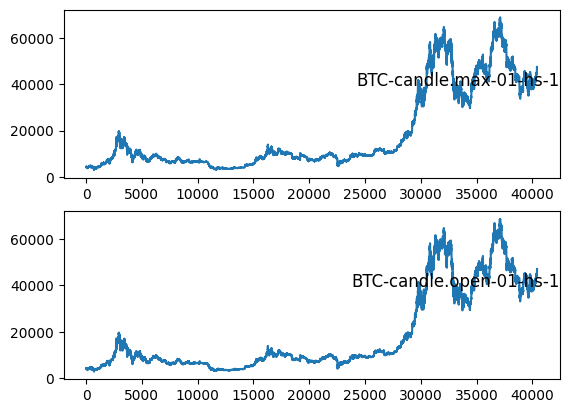

In [12]:
# specify columns to plot
groups = [0, 2]
i = 1
# plot each column
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(timeseries_dataset.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

## Normalization

Normalizing or removing the scale, is a standar prodcedure of any machine learning workflow. 

In [13]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

## Reframing as a Supervised Learning Problem

Each Raw record needs to be expanded with the previous records in order to be suitable for beeing fed into a LSTM model. Some fields of the record at time = 0 will be used as labels and the ones at time < 0 as features.

In [14]:
# frame as supervised learning
reframed = series_to_supervised(scaled, NUMBER_OF_LAG_TIMESTEPS, 1)

In [15]:
reframed

,var1(t-9),var2(t-9),var3(t-9),var4(t-9),var5(t-9),var1(t-8),var2(t-8),var3(t-8),var4(t-8),var5(t-8),...,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t),var2(t),var3(t),var4(t),var5(t)
9,0.020645,0.022006,0.021145,0.021149,0.000998,0.020873,0.022463,0.021865,0.021248,0.000492,...,0.022703,0.024286,0.023666,0.022704,0.000487,0.022846,0.024286,0.023419,0.023435,0.000663
10,0.020873,0.022463,0.021865,0.021248,0.000492,0.021127,0.022738,0.021964,0.021386,0.000153,...,0.022846,0.024286,0.023419,0.023435,0.000663,0.023246,0.024666,0.024148,0.023615,0.001095
11,0.021127,0.022738,0.021964,0.021386,0.000153,0.021196,0.022403,0.022101,0.021776,0.000094,...,0.023246,0.024666,0.024148,0.023615,0.001095,0.023025,0.023104,0.024328,0.021812,0.001449
12,0.021196,0.022403,0.022101,0.021776,0.000094,0.021618,0.023103,0.022237,0.021939,0.000021,...,0.023025,0.023104,0.024328,0.021812,0.001449,0.021262,0.021914,0.022527,0.021840,0.001428
13,0.021618,0.023103,0.022237,0.021939,0.000021,0.022646,0.023509,0.022654,0.023206,0.000228,...,0.021262,0.021914,0.022527,0.021840,0.001428,0.021269,0.021611,0.022555,0.020851,0.001263
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40417,0.661107,0.637794,0.638033,0.657339,0.202918,0.663891,0.655469,0.657575,0.663978,0.100338,...,0.670233,0.671105,0.671771,0.672693,0.029850,0.672551,0.673344,0.672918,0.671649,0.099857
40418,0.663891,0.655469,0.657575,0.663978,0.100338,0.666904,0.663389,0.664209,0.664905,0.132034,...,0.672551,0.673344,0.672918,0.671649,0.099857,0.668527,0.668856,0.671874,0.669344,0.079655
40419,0.666904,0.663389,0.664209,0.664905,0.132034,0.665070,0.666460,0.665135,0.668173,0.040316,...,0.668527,0.668856,0.671874,0.669344,0.079655,0.669947,0.671416,0.669571,0.670630,0.044861
40420,0.665070,0.666460,0.665135,0.668173,0.040316,0.676760,0.668045,0.668401,0.669591,0.129738,...,0.669947,0.671416,0.669571,0.670630,0.044861,0.667725,0.670824,0.670856,0.671117,0.033186


## Train and Test Dataset Preparation

The first part of the dataset will be used to train the model. The last part for calculating the prediction error. Later we will generate the predictions for the test dataset and measure how accurate they were.

In [16]:
# get values from reframed dataset
values = reframed.values
record_count = len(values)
records_for_training = int(record_count * PERCENTAGE_OF_DATASET_FOR_TRAINING / 100)
records_for_training

32330

In [17]:
# split into train and test sets
train = values[:records_for_training, :]
test = values[records_for_training:, :]

In [18]:
train.shape

(32330, 50)

In [19]:
test.shape

(8083, 50)

## Split into Input and Outputs

Here we will split both the Train and the Test datasets into features and labels. 
Features will be all the information where time < 0. For the labels, we will pick only the first 2 fields of each set of indicator properties, which we expect them to contain the Candle Max and Candle Min for each Asset.

In [20]:
# split into input and outputs
n_obs = NUMBER_OF_LAG_TIMESTEPS * NUMBER_OF_FEATURES

train_X = train[:, :n_obs]
train_y = train[:, -NUMBER_OF_FEATURES:-(NUMBER_OF_FEATURES-NUMBER_OF_LABELS)]

test_X = test[:, :n_obs]
test_y = test[:, -NUMBER_OF_FEATURES:-(NUMBER_OF_FEATURES-NUMBER_OF_LABELS)]

In [21]:
train_X

array([[2.0645272e-02, 2.2005606e-02, 2.1144930e-02, ..., 2.3666363e-02,
        2.2704210e-02, 4.8739873e-04],
       [2.0873431e-02, 2.2463445e-02, 2.1864932e-02, ..., 2.3418512e-02,
        2.3434643e-02, 6.6261622e-04],
       [2.1127176e-02, 2.2737693e-02, 2.1963615e-02, ..., 2.4148393e-02,
        2.3614507e-02, 1.0948061e-03],
       ...,
       [7.1735293e-01, 7.1278405e-01, 7.2103208e-01, ..., 7.0659775e-01,
        7.0960891e-01, 3.9517116e-02],
       [7.0787340e-01, 7.1278769e-01, 7.1096200e-01, ..., 7.0980603e-01,
        7.1430814e-01, 5.1062260e-02],
       [7.0755398e-01, 7.1406299e-01, 7.1183151e-01, ..., 7.1452701e-01,
        7.1451163e-01, 6.2090937e-02]], dtype=float32)

In [22]:
train_y

array([[0.02284633, 0.02428612, 0.02341851],
       [0.02324587, 0.02466596, 0.02414839],
       [0.02302528, 0.02310412, 0.02432812],
       ...,
       [0.7119553 , 0.71049863, 0.709806  ],
       [0.7147231 , 0.7150694 , 0.714527  ],
       [0.7199092 , 0.71430767, 0.71470475]], dtype=float32)

## Reshape Inputs to fit LSTM type of Network

This type of Network Architecture requires the features to be in a 3D shape.

In [23]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], NUMBER_OF_LAG_TIMESTEPS, NUMBER_OF_FEATURES))
test_X = test_X.reshape((test_X.shape[0], NUMBER_OF_LAG_TIMESTEPS, NUMBER_OF_FEATURES))

## Network Architecture

Here we are using an LSTM architecture for our neural network. This is the type of architecture usually used for problems involving time-series.

In [24]:
if ACTION_TO_TAKE == "LOAD_MODEL_AND_PREDICT":
    model = load_model('/tf/notebooks/models/' + MODEL_FILE_NAME)

if ACTION_TO_TAKE == "BUILD_AND_SAVE_MODEL":
    # design the network
    model = Sequential()
    model.add(LSTM(NUMBER_OF_LSTM_NEURONS, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(NUMBER_OF_LABELS))
    model.compile(loss='mae', optimizer='adam')

## Fit the Model

We print this output so that the caller program can get the results in a JSON object.

In [25]:
print('{')
print('"trainingOutput": "')

{
"trainingOutput": "


This is the actual process of training the neural network. 

In [26]:
if ACTION_TO_TAKE == "BUILD_AND_SAVE_MODEL":
    # fit network
    history = model.fit(
        train_X, 
        train_y, 
        epochs=NUMBER_OF_EPOCHS, 
        batch_size=72, 
        validation_data=(test_X, test_y), 
        verbose=2, 
        shuffle=False
    )         

In [27]:
print('"')

"


## Save the Model

In [28]:
if ACTION_TO_TAKE == "BUILD_AND_SAVE_MODEL":
    # dave the entire model
    model.save('/tf/notebooks/models/' + MODEL_FILE_NAME)

## Plot Fitting History

In [29]:
if ACTION_TO_TAKE == "BUILD_AND_SAVE_MODEL":
    # plot history
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.legend()
    pyplot.show()

## Batch Prediction of all Test Records

Here we take all Test Records and get a prediction for each one of them. 

In [30]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], NUMBER_OF_LAG_TIMESTEPS*NUMBER_OF_FEATURES))

In [31]:
yhat

array([[0.7463217 , 0.7425063 , 0.7618598 ],
       [0.74774474, 0.74432   , 0.76341444],
       [0.74881595, 0.7451773 , 0.76438785],
       ...,
       [0.7180586 , 0.711705  , 0.7296703 ],
       [0.71827245, 0.7122372 , 0.73024595],
       [0.7184125 , 0.7120944 , 0.73030937]], dtype=float32)

## Reversing Normalization

For inverting the scale (denormalize) of a test record, we need first to unframe the test_X values so as the get the original record. Since the label was the first colum of the record, we concatenate the prediction to the last columns of the framed record.

In [32]:
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -(NUMBER_OF_FEATURES - NUMBER_OF_LABELS):]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,:NUMBER_OF_LABELS]
inv_yhat

array([[52244.547, 51550.797, 52974.01 ],
       [52338.54 , 51669.836, 53076.254],
       [52409.293, 51726.105, 53140.27 ],
       ...,
       [50377.77 , 49529.18 , 50857.098],
       [50391.895, 49564.105, 50894.953],
       [50401.15 , 49554.74 , 50899.125]], dtype=float32)

In [33]:
# invert scaling for actual
inv_y = concatenate((test_y, test_X[:, -(NUMBER_OF_FEATURES - NUMBER_OF_LABELS):]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,:NUMBER_OF_LABELS]
inv_y

array([[50567.91, 50191.26, 50335.67],
       [50395.49, 50043.28, 50257.97],
       [50434.  , 49768.17, 50395.49],
       ...,
       [47200.  , 46884.84, 46904.72],
       [47053.25, 46845.98, 46989.24],
       [47053.25, 46845.98, 46989.24]], dtype=float32)

## Error Calculations

### Main Error Value

In [34]:
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))

This is the main value we use to know how much error there is. We need this value to go as down as possible.

### Alternative Error Analisys

In [35]:
# my way to calculating Errors
errors = (inv_yhat - inv_y) / inv_y * 10000
errors = errors.astype('int') / 100
errors

array([[3.31, 2.7 , 5.24],
       [3.85, 3.25, 5.6 ],
       [3.91, 3.93, 5.44],
       ...,
       [6.73, 5.64, 8.42],
       [7.09, 5.8 , 8.31],
       [7.11, 5.78, 8.32]])

### Plot of the % of Error of each Predicted Value 

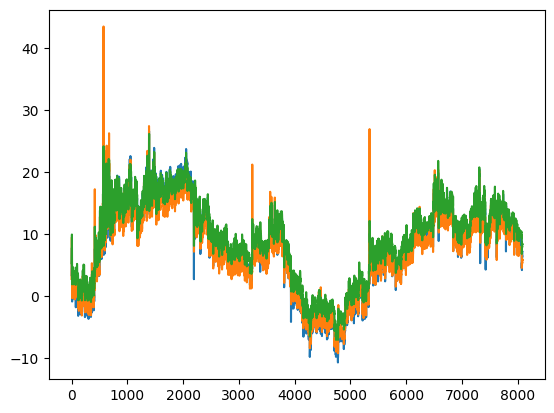

In [36]:
# plot errors
pyplot.plot(errors)
pyplot.show()

### Dollar Difference Between Prediction and Actual Value

In the context of the Test dataset, this is what we get if we substract the Actual Value to the Predicted Value.

In [37]:
diff = (inv_yhat - inv_y) 
diff = diff.astype('float32')
diff

array([[1676.6367, 1359.5352, 2638.3398],
       [1943.0508, 1626.5547, 2818.2852],
       [1975.293 , 1957.9336, 2744.7812],
       ...,
       [3177.7695, 2644.3398, 3952.379 ],
       [3338.6445, 2718.125 , 3905.7148],
       [3347.8984, 2708.7578, 3909.8867]], dtype=float32)

## Returning Predictions & Errors

Here we are returning the predictions to the caller program. Only the last row of predictions are needed because they belong to the latest closed candle. 

In [38]:
print(',"predictions": "', inv_yhat[-1], '"' )

,"predictions": " [50401.15  49554.74  50899.125] "


In [39]:
print(',"errorRMSE": %.3f' % rmse)
print('}')

,"errorRMSE": 4114.664
}


##### 

###### 